In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import norm, multivariate_normal
from scipy.optimize import minimize_scalar
from scipy import integrate, interpolate

In [3]:
# Loading in the data.
def LoadData(energy, key1, key2):
    
    #filename = f'/home/llr/ilc/ritzmann/work/ana_files_ECAL_QGSP_BERT_conf6_e-__GeV_5kevt_build_masked/data_nhits_wenergy_{energy}GeV.txt'
    filename = f'/home/llr/ilc/ritzmann/work/ECAL_QGSP_BERT_conf6_e-_GeV_5kevt_-42_-42_build_masked_data_shower_{energy}GeV.txt'
    df = pd.read_csv(filename, header=0)
    
    return df[[key1, key2]]

data_sum_events = pd.read_csv('/home/llr/ilc/ritzmann/work/ECAL_QGSP_BERT_conf6_e-_GeV_5kevt_-42_-42_build_masked_params_sum_events.txt', header=0)
data_sum_energy_weighted = pd.read_csv('/home/llr/ilc/ritzmann/work/ECAL_QGSP_BERT_conf6_e-_GeV_5kevt_-42_-42_build_masked_params_sum_energy_weighted.txt', header=0)
data_sum_energy_weighted_masking = pd.read_csv('/home/llr/ilc/ritzmann/work/ECAL_QGSP_BERT_conf6_e-_GeV_5kevt_-42_-42_build_masked_params_sum_energy_weighted_masking.txt', header=0)

In [4]:
#calculate the means, and the covariance matrices for all the different energies
Energies = [0.25, 0.5, 0.7, 1, 2, 5, 8, 10, 20, 40, 60, 80, 100, 150, 200, 250]
#Energies = [1, 2, 5, 8, 10, 20]

means1 = []
means2 = []
sigmas1 = []
sigmas2 = []
rhos = []

for energy in Energies:
    df = LoadData(energy, 'wnhits', 'wenergy2')
    mean = np.mean(df.to_numpy(), axis=0)
    cov = np.cov(df.to_numpy(), rowvar=0)
    sigma1 = np.sqrt(cov[0][0])
    sigma2 = np.sqrt(cov[1][1])
    #rho_new = cov[1][0]
    rho = cov[1][0]/(sigma1*sigma2)
    means1.append(mean[0])
    means2.append(mean[1])
    sigmas1.append(sigma1)
    sigmas2.append(sigma2)
    rhos.append(rho)
    
df1 = pd.DataFrame({
    
    'energy': Energies,
    'mean_nhit':means1,
    'mean_sumE':means2,
    'sigma_nhit':sigmas1,
    'sigma_sumE':sigmas2,
    'rhoNew':rhos
})
df1

,energy,mean_nhit,mean_sumE,sigma_nhit,sigma_sumE,rhoNew
0,0.25,10.196140,17.924750,3.292144,9.346572,0.624539
1,0.50,19.051486,37.116136,4.571822,13.099297,0.603306
2,0.70,25.312691,52.737610,5.315432,15.730817,0.598834
3,1.00,34.422654,75.602033,6.326158,19.038108,0.574832
4,2.00,61.180430,156.878458,8.643864,27.101295,0.559168
5,5.00,127.262456,402.632936,12.851437,44.640552,0.543496
6,8.00,183.122207,654.971861,15.541047,58.065189,0.523541
7,10.00,217.464612,824.301761,16.615693,64.852085,0.497481
8,20.00,363.207064,1681.935758,22.468156,95.803691,0.472379
9,40.00,591.727492,3416.270156,30.899720,141.990260,0.450485


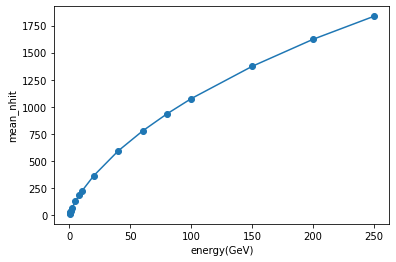

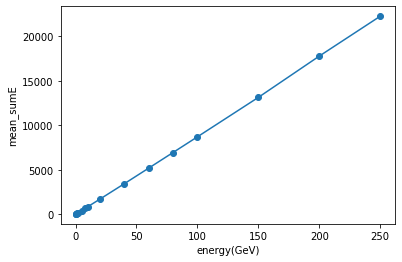

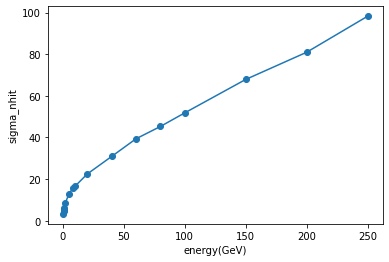

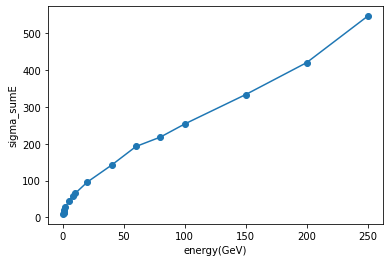

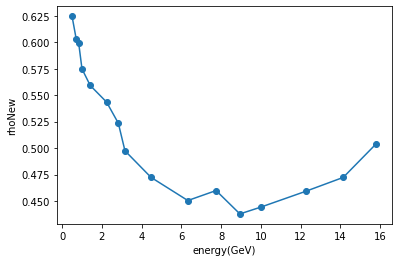

In [5]:
# drawing linearity plots for each of them
#df2 = df1
#Nmax=len(df2)
#df1 = df2[:Nmax]
plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['mean_nhit'], 'o-')
plt.plot(df1['energy'], df1['mean_nhit'], 'o-')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.ylabel('mean_nhit')
plt.xlabel('energy(GeV)')
plt.show()
plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['mean_sumE'], 'o-')
plt.plot(df1['energy'], df1['mean_sumE'], 'o-')
plt.ylabel('mean_sumE')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()
plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['sigma_nhit'], 'o-')
plt.plot(df1['energy'], df1['sigma_nhit'], 'o-')
plt.ylabel('sigma_nhit')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()
plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['sigma_sumE'], 'o-')
plt.plot(df1['energy'], df1['sigma_sumE'], 'o-')
plt.ylabel('sigma_sumE')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()

plt.figure()
#plt.plot(1/np.sqrt(df1['energy']), df1['rhoNew'], 'o-')
plt.plot(np.sqrt(df1['energy']), df1['rhoNew'], 'o-')
plt.ylabel('rhoNew')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()


In [6]:
def parabola(x, a, b, c, d):
    y = a*x*x*x + b*x*x + c*x + d
    return y
'''
nhit_params, nhit_params_cov = curve_fit(f=parabola,
                          ydata = df1['mean_nhit'],
                          xdata = df1['energy'])
                            #xdata = 1/np.sqrt(df1['energy']))
sumE_params, sumE_params_cov = curve_fit(f=parabola,
                          ydata = df1['mean_sumE'],
                          xdata = df1['energy'])
                            #xdata = 1/np.sqrt(df1['energy']))
sigma_nhit_params, sigma_nhit_params_cov = curve_fit(f=parabola,
                          ydata = df1['sigma_nhit'],
                          xdata = df1['energy'])
                            #xdata = 1/np.sqrt(df1['energy']))
sigma_sumE_params, sigma_sumE_params_cov = curve_fit(f=parabola,
                          ydata = df1['sigma_sumE'],
                          xdata = df1['energy'])
                            #xdata = 1/np.sqrt(df1['energy']))
rhoNew_params, rhoNew_params_cov = curve_fit(f=parabola,
                          ydata = df1['rhoNew'],
                            xdata = df1['energy'])
                          #xdata = 1/np.sqrt(df1['energy']))
'''
f_nhits_mean = interpolate.interp1d(df1['energy'], df1['mean_nhit'], kind = 'cubic', fill_value='extrapolate')
f_sumE_mean = interpolate.interp1d(df1['energy'], df1['mean_sumE'], kind = 'cubic', fill_value='extrapolate')
f_nhits_sigma = interpolate.interp1d(df1['energy'], df1['sigma_nhit'], kind = 'cubic', fill_value='extrapolate')
f_sumE_sigma = interpolate.interp1d(df1['energy'], df1['sigma_sumE'], kind = 'cubic', fill_value='extrapolate')
f_rhoNew = interpolate.interp1d(df1['energy'], df1['rhoNew'], kind = 'cubic', fill_value='extrapolate')

In [58]:
print(nhit_params, np.sqrt(np.diag(nhit_params_cov)))
print(sumE_params, np.sqrt(np.diag(sumE_params_cov)))
print(sigma_nhit_params, np.sqrt(np.diag(sigma_nhit_params_cov)))
print(sigma_sumE_params, np.sqrt(np.diag(sigma_sumE_params_cov)))
print(rhoNew_params, np.sqrt(np.diag(rhoNew_params_cov)))

[ 2.61175164e-04 -8.47439126e-02  1.31181785e+01  3.03622265e+01] [5.11826611e-05 1.15098403e-02 6.44803398e-01 6.63164411e+00]
[-7.45159951e-02  2.62547154e+01  1.58156363e+04 -6.99545371e+03] [1.29549180e-02 2.91327251e+00 1.63207126e+02 1.67854482e+03]
[ 1.43582972e-05 -4.22226679e-03  6.47459873e-01  5.85934947e+00] [4.17930838e-06 9.39833336e-04 5.26512722e-02 5.41505366e-01]
[ 1.05696313e-02 -3.53466977e+00  1.02955103e+03  3.57538944e+03] [3.98514247e-03 8.96169758e-01 5.02051546e+01 5.16347627e+02]
[ 4.42280471e-01 -2.31760427e+02  7.15879857e+03  9.10251834e+03] [1.45329951e-01 3.26814692e+01 1.83087882e+03 1.88301378e+04]


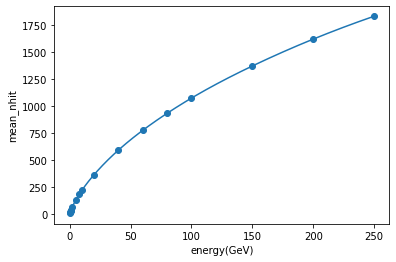

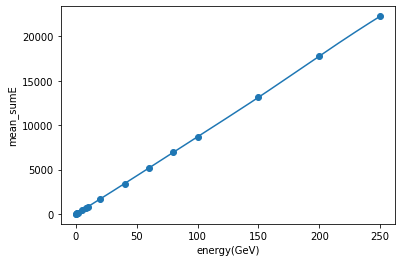

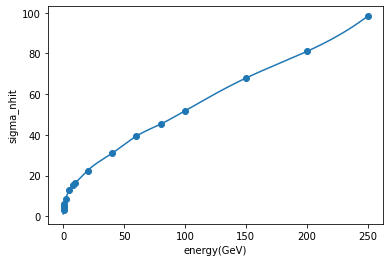

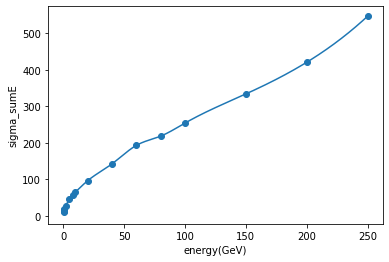

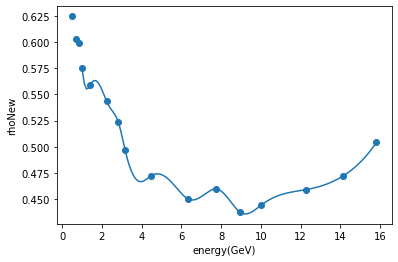

In [9]:
# drawing linearity plots for each of them
#df2 = df1
#Nmax=len(df2)
#df1 = df2[:Nmax]

plt.figure()
x = np.linspace(0, df1['energy'].max(), 1000)
#y = parabola(x, nhit_params[0], nhit_params[1], nhit_params[2], nhit_params[3])
y = f_nhits_mean(x)
plt.plot(x, y)
plt.scatter(df1['energy'], df1['mean_nhit'])
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.ylabel('mean_nhit')
plt.xlabel('energy(GeV)')
plt.show()

plt.figure()
x = np.linspace(0, df1['energy'].max(), 1000)
#y = parabola(x, sumE_params[0], sumE_params[1], sumE_params[2], sumE_params[3])
y = f_sumE_mean(x)
plt.plot(x, y)
plt.scatter(df1['energy'], df1['mean_sumE'])
plt.ylabel('mean_sumE')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()

plt.figure()
x = np.linspace(0, df1['energy'].max(), 1000)
#y = parabola(x, sigma_nhit_params[0], sigma_nhit_params[1], sigma_nhit_params[2],  sigma_nhit_params[3])
y = f_nhits_sigma(x)
plt.plot(x, y)
plt.scatter(df1['energy'], df1['sigma_nhit'])
plt.ylabel('sigma_nhit')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()

plt.figure()
x = np.linspace(0, df1['energy'].max(), 1000)
#y = parabola(x, sigma_sumE_params[0], sigma_sumE_params[1], sigma_sumE_params[2], sigma_sumE_params[3])
y = f_sumE_sigma(x)
plt.plot(x, y)
plt.scatter(df1['energy'], df1['sigma_sumE'], )
plt.ylabel('sigma_sumE')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()

plt.figure()
x = np.linspace(1, df1['energy'].max(), 1000)
#y = parabola(x, rhoNew_params[0], rhoNew_params[1], rhoNew_params[2], rhoNew_params[3])
y = f_rhoNew(x)
plt.plot(np.sqrt(x), y)
plt.scatter(np.sqrt(df1['energy']), df1['rhoNew'])
plt.ylabel('rhoNew')
plt.xlabel('energy(GeV)')
#plt.ylim(0, df2['energy'][Nmax-1]+1)
plt.show()


In [10]:
# Idea: Make a list of energies; calculate the bigaus parameters for all of them.
# Then take a random point (nhit, sum_E) and find the distribution with the greatest prob. density. that it could belong to.
energies = np.linspace(0.3, 265, 20000)
'''
nhits = []
sumE = []
sigma_nhits = []
sigma_sumE = []
rhonew = []
for energy in energies:
    nhits_sol = parabola(energy, nhit_params[0], nhit_params[1], nhit_params[2], nhit_params[3])
    sumE_sol = parabola(energy, sumE_params[0], sumE_params[1], sumE_params[2], sumE_params[3])
    sigma_nhits_sol = parabola(energy, sigma_nhit_params[0], sigma_nhit_params[1], sigma_nhit_params[2], sigma_nhit_params[3])
    sigma_sumE_sol = parabola(energy, sigma_sumE_params[0], sigma_sumE_params[1], sigma_sumE_params[2], sigma_sumE_params[3])
    rhonew_sol = parabola(energy, rhoNew_params[0], rhoNew_params[1], rhoNew_params[2], rhoNew_params[3])
    nhits.append(nhits_sol)
    sumE.append(sumE_sol)
    sigma_nhits.append(sigma_nhits_sol)
    sigma_sumE.append(sigma_sumE_sol)
    rhonew.append(rhonew_sol)
'''    
nhits = []
sumE = []
sigma_nhits = []
sigma_sumE = []
rhonew = []
for energy in energies:
    nhits_sol = f_nhits_mean(energy)
    sumE_sol = f_sumE_mean(energy)
    sigma_nhits_sol = f_nhits_sigma(energy)
    sigma_sumE_sol = f_sumE_sigma(energy)
    rhonew_sol = f_rhoNew(energy)
    nhits.append(nhits_sol)
    sumE.append(sumE_sol)
    sigma_nhits.append(sigma_nhits_sol)
    sigma_sumE.append(sigma_sumE_sol)
    rhonew.append(rhonew_sol)

In [11]:
# Create a bivariate normal distribution for each energy
normdist = []
for i in range(len(energies)):
    energy = energies[i] 
    mean = [nhits[i], sumE[i]]# this will be the mean.
    cov = np.eye(2)
    cov[0][0] = sigma_nhits[i]**2.0
    cov[1][1] = sigma_sumE[i]**2.0
    cov[1][0] = rhonew[i]*sigma_nhits[i]*sigma_sumE[i]
    cov[0][1] = rhonew[i]*sigma_nhits[i]*sigma_sumE[i]
    # cov will be the covariance matrix.
    var = multivariate_normal(mean=mean, cov=cov)
    # var will be the multivariate normal distribution.
    normdist.append(var)

In [12]:
#check if the distribution is really normalized
print(normdist[4].cdf((np.inf,np.inf)))
#print(point)
#print(mean_points)

point = np.array([[5, 60000]])
mean_points = np.array([nhits, sumE]).T
#print(mean_points)
print(np.sum((mean_points - point)**2, axis=1))

1.0
[3.59740083e+09 3.59728078e+09 3.59716024e+09 ... 1.33472203e+09
 1.33464491e+09 1.33456780e+09]


In [19]:
#def probability(x, y, normdist=normdist):
 #   point = [x, y]
  #  probs = []
   # for i in range(len(normdist)):
   #     probs.append(normdist[i].pdf(point))
    #return probs
#probability = np.vectorize(probability)

def probability(x, y, normdist = normdist):
    #1) from the list of distributions find the mean values closest to the point
    #2) calculate the pdf of this point for all distributions whose mean value lies within a radius of 3 sigmas to the point found in 1) 
    point = np.array([x , y])
    probs = []
    distance = np.sum((mean_points - point)**2, axis=1)
    index_closest_point = np.argmin(distance)
    #print(index_closest_point)
    if index_closest_point < 1000:
        #subset_normdist = normdist[:index_closest_point+1000]
        subset_normdist = normdist[:2000]
        index = 0
    elif index_closest_point >18999:
        #subset_normdist = normdist[index_closest_point-1000:]
        subset_normdist = normdist[-2000:]
        index = 18000
    else :
        subset_normdist = normdist[index_closest_point-1000:index_closest_point+1000]
        index = index_closest_point-1000
    #print(subset_normdist)
    for i in range(len(subset_normdist)):
        probs.append(subset_normdist[i].pdf(point))
    return index, probs
probability=np.vectorize(probability)
        
    
for energy in Energies:
    df=df.append(LoadData(energy, 'wnhits', 'wenergy2'))
df

,wnhits,wenergy2
0,1806.32,21778.3
1,1748.10,22357.0
2,1871.24,22194.5
3,1798.36,21700.8
4,1964.85,22673.3
...,...,...
2915,1951.33,22284.4
2916,1788.39,22249.4
2917,1844.10,22776.2
2918,1869.99,22649.1


In [22]:
Ntrials=1000
res=[]
e=[]
std_dev=[]
Energies = [0.25, 0.5, 0.7, 1, 2, 5, 8, 10, 20, 40, 60, 80, 100, 150, 200, 250]
#Energies = [1, 2, 5, 8, 10, 20]
for energy, mean_hit, mean_sumE in zip(Energies, means1, means2):
    print(f"Energy(GeV):{energy}")
    df = LoadData(energy, 'wnhits', 'wenergy2')
    trials = []
    for i in range(Ntrials):
        randint = np.random.randint(0,len(df))
        point = df.iloc[randint].to_numpy()
        index, prob = probability(point[0],point[1]) #maybe change probability, such that only 
        trials.append(energies[np.argmax(prob)+index])
    trials = np.array(trials)
    print(f"After {Ntrials} trials,estimated energy:{trials.mean().round(3)}, with std: {trials.std().round(3)}, and resolution:{np.round(trials.std()/trials.mean(), 3)}")
    res.append(trials.std()/trials.mean())
    e.append(trials.mean())
    std_dev.append(trials.std())
print(f"Lower Bound on Resolution:{(np.max(energies)-np.min(energies))/len(energies)} due to spacing")


Energy(GeV):0.25
After 1000 trials,estimated energy:0.493, with std: 0.137, and resolution:0.277
Energy(GeV):0.7
After 1000 trials,estimated energy:0.679, with std: 0.167, and resolution:0.245
Energy(GeV):1
After 1000 trials,estimated energy:0.992, with std: 0.207, and resolution:0.208
Energy(GeV):2
After 1000 trials,estimated energy:1.968, with std: 0.299, and resolution:0.152
Energy(GeV):5
After 1000 trials,estimated energy:4.967, with std: 0.511, and resolution:0.103
Energy(GeV):8
After 1000 trials,estimated energy:7.98, with std: 0.658, and resolution:0.082
Energy(GeV):10
After 1000 trials,estimated energy:10.038, with std: 0.742, and resolution:0.074
Energy(GeV):20
After 1000 trials,estimated energy:19.938, with std: 1.101, and resolution:0.055
Energy(GeV):40
After 1000 trials,estimated energy:39.932, with std: 1.583, and resolution:0.04
Energy(GeV):60
After 1000 trials,estimated energy:59.966, with std: 2.02, and resolution:0.034
Energy(GeV):80
After 1000 trials,estimated energy:

In [23]:
print(e)
print(std_dev)

[0.31589602980149, 0.4928303565178258, 0.6785531626581329, 0.9923574678733936, 1.9681831041552078, 4.966973758687935, 7.980336876843841, 10.037542552127606, 19.9381219860993, 39.932177388869434, 59.96572800640031, 79.92797811390568, 99.88149268463421, 149.88486993349667, 199.7880929296465, 249.5325144557228]
[0.043775035986355286, 0.1366156510349929, 0.16650746540330086, 0.20653566365732404, 0.2993412894797135, 0.510686782361554, 0.6575630527377815, 0.7423278434091994, 1.1014111455275801, 1.5833730358827929, 2.0198357844993278, 2.4628037445951345, 2.8146205040347394, 3.484279361433691, 4.608742136812576, 6.686732218890431]


In [70]:

#std_dev = np.array([0.198, 0.322, 0.572, 0.72, 0.811, 1.198, 1.835, 2.371, 2.878, 3.73, 3.807])
Energies = np.array([0.25, 0.5, 0.7, 1, 2, 5, 8, 10, 20, 40, 60, 80, 100, 150, 200, 250])

#predicted energies, the resolution and the corresponding uncertainty for 1000 trials with sampling only over
#a restricted range and directly calculating the mean values and the convariance!
df_1000_quick_mean_cov = pd.DataFrame({
    'energy': e,
    'resolution':res,
    'standard_dev':std_dev
    
})
df_1000_quick_mean_cov

,energy,resolution,standard_dev
0,1.236299,0.182051,0.225070
1,2.079835,0.156599,0.325699
2,5.041784,0.113071,0.570079
3,8.167778,0.087737,0.716616
4,10.213293,0.074411,0.759982
5,20.220779,0.056331,1.139058
6,39.793605,0.046136,1.835905
7,59.602616,0.040011,2.384787
8,79.697363,0.036689,2.924048
9,100.287385,0.033809,3.390609


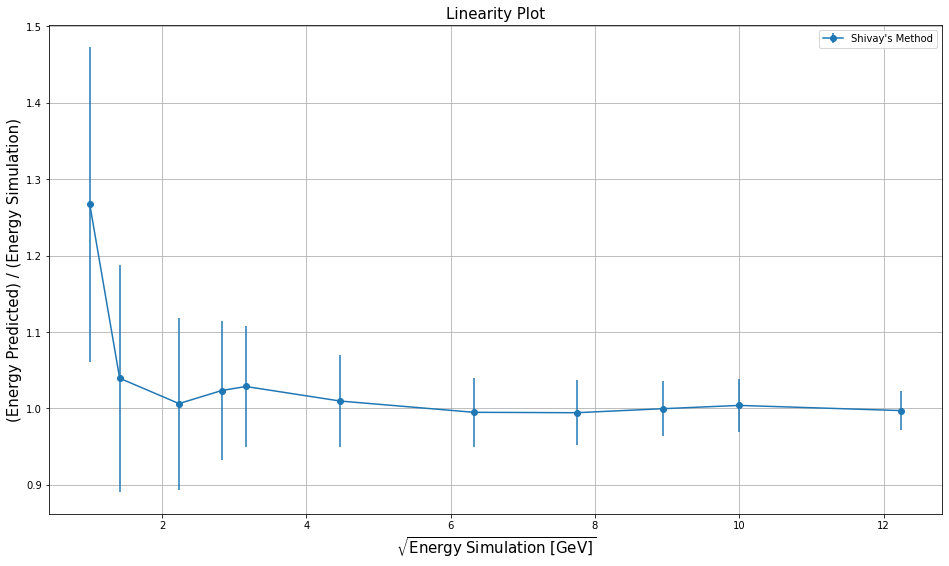

In [67]:
df_1000_quick_mean
plt.figure(figsize=(16,9), facecolor='white')
plt.errorbar(np.sqrt(Energies), np.array(df_1000_quick_mean['energy'])/Energies, yerr = np.array(df_1000_quick_mean['standard_dev'])/Energies, fmt='o-', label = 'Shivay\'s Method')
plt.grid()
plt.title('Linearity Plot', fontsize = 15)
plt.xlabel('$\sqrt{\mathrm{Energy\;Simulation\;[GeV]}}$', fontsize = 15)
plt.ylabel('(Energy Predicted) / (Energy Simulation)', fontsize = 15)
plt.legend()

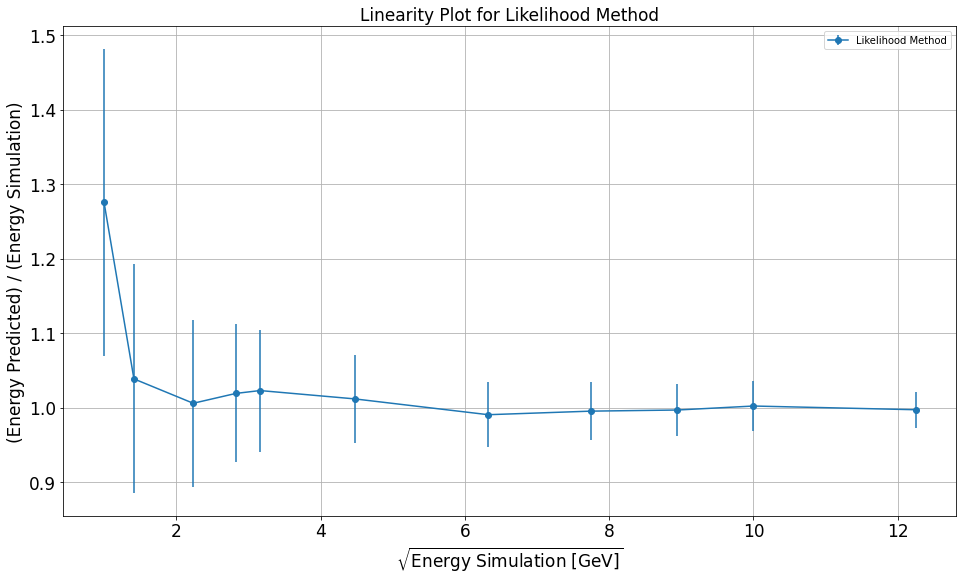

In [96]:
plt.figure(figsize=(16,9), facecolor='white')
plt.errorbar(np.sqrt(Energies), np.array(e)/Energies, yerr = np.array(std_dev)/Energies, fmt='o-', label = 'Likelihood Method')
plt.grid()
plt.title('Linearity Plot for Likelihood Method', fontsize = 17)
plt.xlabel('$\sqrt{\mathrm{Energy\;Simulation\;[GeV]}}$', fontsize = 17)
plt.ylabel('(Energy Predicted) / (Energy Simulation)', fontsize = 17)
plt.legend()
plt.yticks(size=17)
plt.xticks(size=17)
#plt.xlim(0,35)
#plt.ylim(0,35)
plt.savefig('/home/llr/ilc/ritzmann/work/ratio_linearity_plot_shivay_1000trials_quick_mean.png', transparent=False)

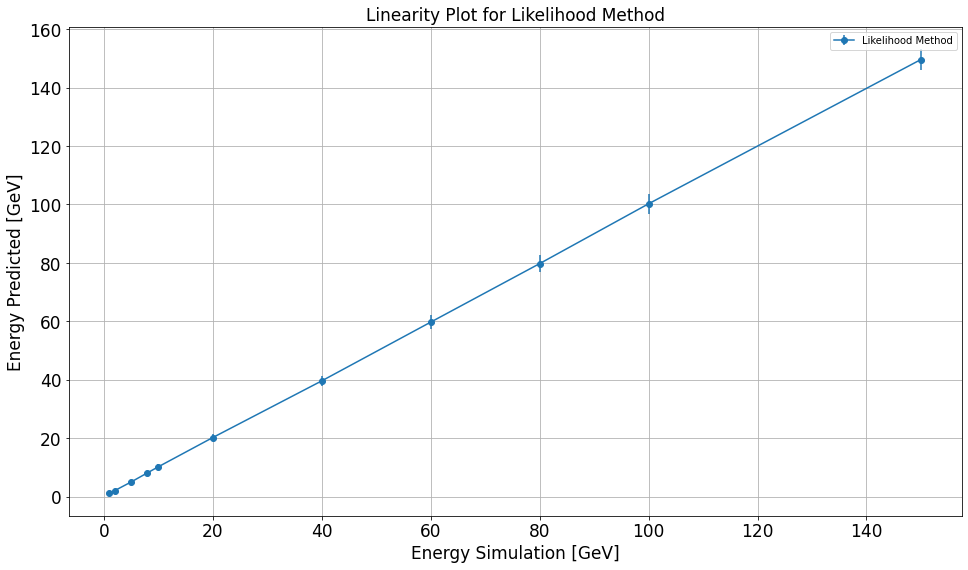

In [95]:
plt.figure(figsize=(16,9), facecolor='white')
plt.errorbar(Energies, np.array(e), yerr = np.array(std_dev), fmt='o-', label = 'Likelihood Method')
plt.grid()
plt.title('Linearity Plot for Likelihood Method', fontsize=17)
plt.xlabel('Energy Simulation [GeV]', fontsize=17)
plt.ylabel('Energy Predicted [GeV]', fontsize=17)
plt.legend()
plt.yticks(size = 17)
plt.xticks(size = 17)
#plt.xlim(0,35)
#plt.ylim(0,35)
plt.savefig('/home/llr/ilc/ritzmann/work/linearity_plot_shivay_1000trials_quick_mean.png', transparent=False)